<a href="https://colab.research.google.com/github/itssofiarce/AAII-TUIA-Alomar-Arce/blob/main/AAII_TUIA_Alomar_Arceipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparación del entorno

In [ ]:
!pip install -q gdown

In [ ]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import gdown
import os.path as osp
import zipfile

# TP1-1-student_performance.zip
DATA_TP1_1='https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc'
# TP1-2-diabetes.zip
DATA_TP1_2='https://drive.google.com/uc?id=14-fDOsI9mrosOd-2Pnj8GdP1jyZjUTq_'
# TP1-3-natural-scenes.zip
DATA_TP1_3='https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ'

count=0
while count != 3:
  data = [DATA_TP1_1, DATA_TP1_2, DATA_TP1_3][count]
  # Descargo
  var = gdown.download(data)
  # Extraigo
  with zipfile.ZipFile(f'{var}', 'r') as zip_ref:
    zip_ref.extractall(f'./TP1-{count+1}')

  # Variable que almacena el path de los datasets extraídos
  globals()[f"DATA_DIRECTORY_TP1_{count+1}"] = osp.abspath(f'TP1-{count+1}')

  count += 1


Downloading...
From: https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc
To: /content/TP1-1-student_performance.zip
100%|██████████| 49.7k/49.7k [00:00<00:00, 62.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=14-fDOsI9mrosOd-2Pnj8GdP1jyZjUTq_
To: /content/TP1-2-diabetes.zip
100%|██████████| 9.13k/9.13k [00:00<00:00, 24.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=b3161bdf-73e9-43b2-8ea5-8c47e4cf969a
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:12<00:00, 29.9MB/s]


Establecer gpu por defecto:


In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Problema 3

Construir modelos de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar las imágenes en las siguientes categorías:
- *buildings*
- *forest*
- *glacier*
- *mountain*
- *sea*
- *street*

Arquitectura de los modelos:

- Modelo con **capas densas**
- Modelo con **capas convolucionales**
- Modelo que  inlcuya **bloques residuales de identidad**
- Modelo que utilice como *backbone* alguna de las arquitecturas disponibles en TensorFlow (*transfer learning*)


In [ ]:
# Tamaño del lote (batch size)
BATCH_SIZE = 64
# Tamaño de las imágenes
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    f'{DATA_DIRECTORY_TP1_3}/seg_train/seg_train',
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f'{DATA_DIRECTORY_TP1_3}/seg_test/seg_test',
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 3000 files belonging to 6 classes.
Using 600 files for validation.


In [ ]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


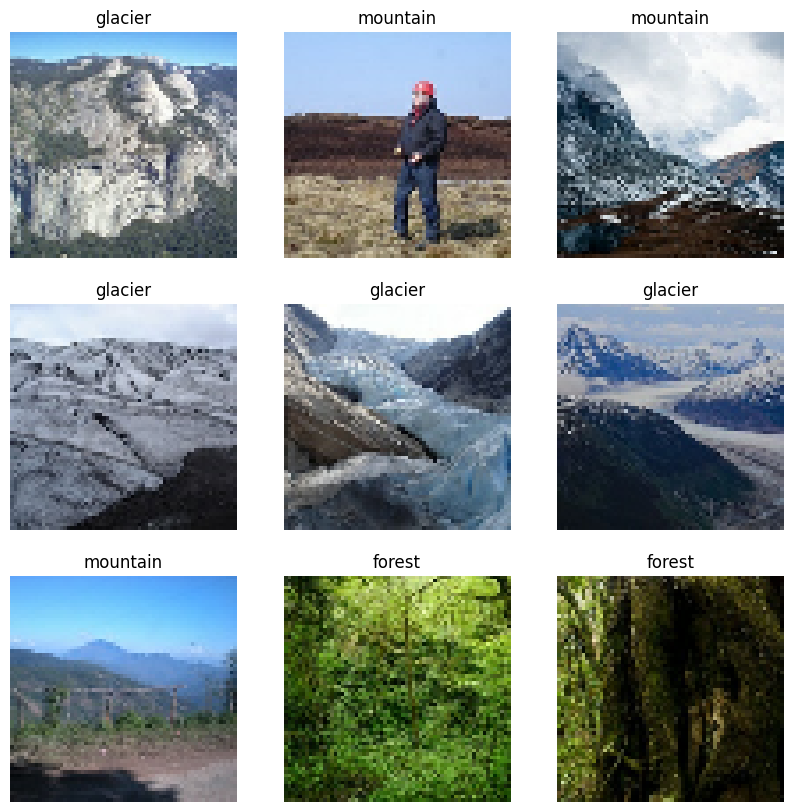

In [ ]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

# Preprocesamiento del dataset


## ¿Las clases estan balanceadas?


In [ ]:
import os

# Contar la longitud de las carpetas
dataset_dir = f'{DATA_DIRECTORY_TP1_3}/seg_train/seg_train'
class_counts = {}

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):  # Verifica que sea un directorio
        image_count = len(os.listdir(class_path))
        class_counts[class_name] = image_count

# Imprimir los resultados
for class_name, count in class_counts.items():
    print(f'{class_name}: {count} imágenes')


forest: 2271 imágenes
mountain: 2512 imágenes
sea: 2274 imágenes
glacier: 2404 imágenes
buildings: 2191 imágenes
street: 2382 imágenes


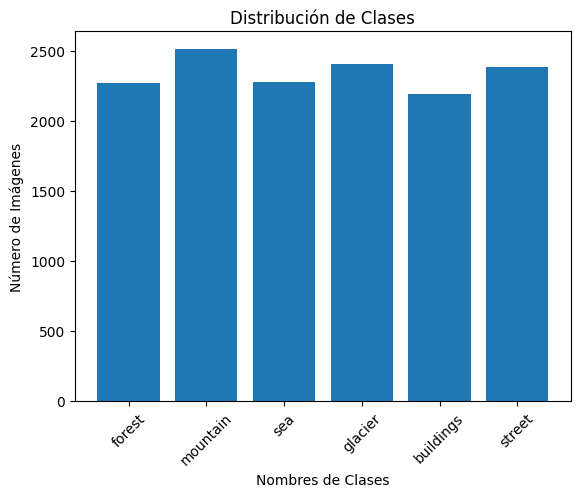

In [ ]:
# Bar chart to visualize class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Nombres de Clases')
plt.ylabel('Número de Imágenes')
plt.title('Distribución de Clases')
plt.xticks(rotation=45)
plt.show()

Las clases tienen un leve desbalanceo predominando la clase *mountain* con 2512 ejemplos de imagenes, mientras que la clase con menor cantidad de samples es la de *buildings* con 2191.




# Modelo convolucional de capas densas

Para el modelo de capas densas, las imagenes fueron normalizadas y pasadas a escalas de grises.

In [ ]:
from tensorflow.keras.models import Sequential

In [ ]:
def grayscale(image):
    return tf.image.rgb_to_grayscale(image)

train_ds = train_ds.map(lambda image, label: (grayscale(image), label))
val_ds = val_ds.map(lambda image, label: (grayscale(image), label))

In [ ]:
# Normalizamos los datos
def normalize(image, label):
  """Normalizes image pixel values."""
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

# Apply the normalization function to each element in the datasets
X_train = train_ds.map(normalize)
X_test = val_ds.map(normalize)

In [ ]:
# Modelo de capas densas
model = Sequential([
    Flatten(input_shape=(64, 64)),
    Dense(64, activation='relu'),  # Capa densa intermedia con más neuronas
    Dense(32, activation='relu'),  # Capa existente
    Dense(16, activation='relu'),  # Capa existente
    Dense(6, activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Definimos su arquitectura


Compilamos el modelo

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Observamos sus métricas

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,918 (1.01 MB)

 Trainable params: 264,918 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo

In [ ]:
# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:567: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.1987 - loss: 61.2177 - val_accuracy: 0.1517 - val_loss: 1.8127
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.1568 - loss: 1.7942 - val_accuracy: 0.1633 - val_loss: 1.7948
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.1799 - loss: 1.7908 - val_accuracy: 0.1633 - val_loss: 1.7916
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1793 - loss: 1.7883 - val_accuracy: 0.1633 - val_loss: 1.7899
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.1794 - loss: 1.7906 - val_accuracy: 0.1633 - val_loss: 1.7900
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.1780 - loss: 1.7904 - val_accuracy: 0.1633 - val_loss: 1.7904
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.1801 - loss: 1.7914 - val_accuracy: 0.1633 - val_loss: 1.7905
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.1815 - loss: 1.7904 - val_accuracy: 0.1

Con las redes de capas densas no se llega a un muy buen resultado. Hay overfiting.

# Modelo convolucional de capas convolucionales

Para el modelo de capas convolucionales se les dará como input las imagenes a color y luego en escalas de grises

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Tamaño del lote (batch size)
BATCH_SIZE = 64
# Tamaño de las imágenes
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    f'{DATA_DIRECTORY_TP1_3}/seg_train/seg_train',
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f'{DATA_DIRECTORY_TP1_3}/seg_test/seg_test',
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 3000 files belonging to 6 classes.
Using 600 files for validation.


In [ ]:
num_classes = len(class_names)

# Definición del modelo usando Sequential
model = models.Sequential([

    # Escalado
    layers.Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_HEIGHT,
                                   IMAGE_WIDTH,
                                   3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),

    # Capa convolucional 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),

    # Capa convolucional 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Dropout
    layers.Dropout(0.3),

    # Capa convolucional 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Aplanar la salida para las capas densas
    layers.Flatten(),

    # Capa de salida
    layers.Dense(6, activation='softmax')  # 6 categorías
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │          27,654 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,902 (472.27 KB)

 Trainable params: 120,902 (472.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.4326 - loss: 1.4134 - val_accuracy: 0.5667 - val_loss: 1.2372
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6266 - loss: 0.9734 - val_accuracy: 0.6183 - val_loss: 1.1118
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6655 - loss: 0.8919 - val_accuracy: 0.6783 - val_loss: 0.8925
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6891 - loss: 0.8226 - val_accuracy: 0.7400 - val_loss: 0.7268
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7247 - loss: 0.7572 - val_accuracy: 0.6900 - val_loss: 0.8629
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7379 - loss: 0.7275 - val_accuracy: 0.7217 - val_loss: 0.7877
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7532 - loss: 0.6913 - val_accuracy: 0.7500 - val_loss: 0.7018
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7609 - loss: 0.6716 - val_acc

En las primeras corridas, la red tuvo mucho overfiting:
train_accuracy:75% vs val_accuracy: 73% por lo que se aplicó Dropout para mejorar esos resultados.

76/176 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8337 - loss: 0.4556 - val_accuracy: 0.7900 - val_loss: 0.6188 --> agrego droput



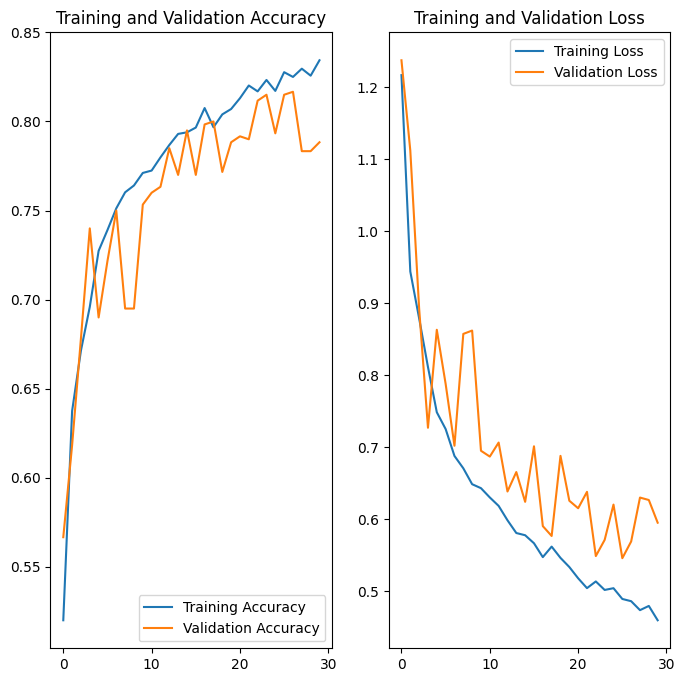

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Segun el grafico de arriba, hay overfitting. Aunque a medida que pasan las epocas se puede ver como disminuye el error en training como en testing.

# Modelo profundo con bloques residuales

In [ ]:
def residual_block(x, filters):
    # Primer convolucional
    shortcut = x  # Guarda la entrada para la conexión residual
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Segundo convolucional
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Ajusta el shortcut si el número de filtros no coincide
    if x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)

    # Suma la entrada original (shortcut) con la salida
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


In [ ]:
# Definir el modelo usando Functional API en lugar de Sequential para manejar bloques residuales
inputs = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = layers.Rescaling(1./255)(inputs)
x = layers.RandomFlip("horizontal")(x)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)

# Primer bloque residual
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 32)

# Segundo bloque residual
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64)

# Tercer bloque residual
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 128)

# Aplanar la salida para las capas densas
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation='softmax')(x)  # 6 categorías

# Crear el modelo funcional
model = models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 64, 64, 3)      │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip_1             │ (None, 64, 64, 3)      │              0 │ rescaling_1[0][0]      │
│ (RandomFlip)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation_1         │ (None, 64, 64, 3)      │              0 │ random_flip_1[0][0]    │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_zoom_1             │ (None, 64, 64, 3)      │              0 │ random_rotation_1[0][… │
│ (RandomZoom)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │            896 │ random_zoom_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 32)     │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 32)     │            128 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 32)     │              0 │ batch_normalization_1… │
│                           │                        │                │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 32)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 16, 16, 32)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d_4[0][0]  │
├──────────────────────

 Total params: 1,357,958 (5.18 MB)

 Trainable params: 1,357,062 (5.18 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Compilar el modelo
model.compile(
    optimizer='adam',  # Puedes ajustar el optimizador si es necesario
    loss='categorical_crossentropy',  # O 'sparse_categorical_crossentropy' dependiendo de cómo estén etiquetadas tus clases
    metrics=['accuracy']  # Métricas para monitorear
)

# Número de épocas de entrenamiento
EPOCHS = 30

# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.3310 - loss: 2.0605 - val_accuracy: 0.4950 - val_loss: 1.3349
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.4778 - loss: 1.2442 - val_accuracy: 0.6133 - val_loss: 1.0305
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.5503 - loss: 1.1264 - val_accuracy: 0.5967 - val_loss: 1.0336
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.6111 - loss: 1.0032 - val_accuracy: 0.6517 - val_loss: 0.8937
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.6510 - loss: 0.9439 - val_accuracy: 0.7583 - val_loss: 0.6898
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6831 - loss: 0.8726 - val_accuracy: 0.6250 - val_loss: 1.0703
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.7025 - loss: 0.8179 - val_accuracy: 0.7583 - val_loss: 0.7319
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7344 - loss: 0.7708 - val_ac

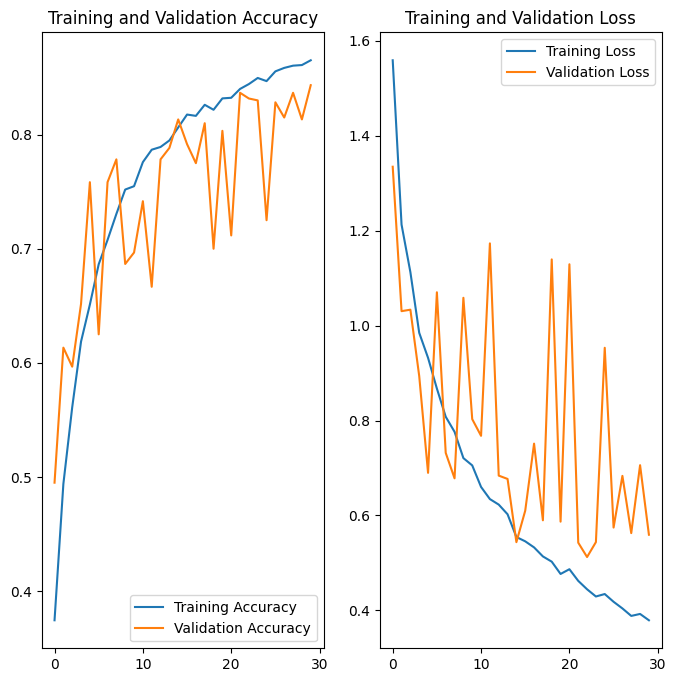

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Aunque se esperaría que al agregar bloques residuales la performance del modelo mejore, las arquitecturas resnet son óptimas para las arquitecturas de muchas capas convolucionales en nuestra arquitectura de 3 capas convolucionas los resultados con bloques resnet no mejoran los resultados de la red.

# Transfer Learning con Inception


Inception tiene una arquitectura de red neuronal convolucional profunda (CNN) que se entrenó en el conjunto de datos de ImageNet.

Inception v3 es conocido por su alta precisión y capacidad para clasificar imágenes en una gran cantidad de categorías. Consiste en varias capas de operaciones convolucionales y de agrupación, seguidas de capas totalmente conectadas y softmax para la clasificación.

Utilizaremos InceptionV3 como backbone para entrenar el modelo con nuestro dataset.

In [ ]:
IMAGE_WIDTH = 229
IMAGE_HEIGHT = 229
BATCH_SIZE = 32

In [ ]:
# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    f'{DATA_DIRECTORY_TP1_3}/seg_train/seg_train',
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f'{DATA_DIRECTORY_TP1_3}/seg_test/seg_test',
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 3000 files belonging to 6 classes.
Using 600 files for validation.


In [ ]:
tf.random.set_seed(23)

inputs = tf.keras.layers.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT) + (3,))

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

model_chain = base_model(inputs)
model_chain = tf.keras.layers.GlobalAveragePooling2D()(model_chain)
model_chain = tf.keras.layers.Dense(num_classes, activation="softmax")(model_chain)

model1a = tf.keras.Model(inputs, model_chain)

In [ ]:
EPOCHS = 10

def train_model(model, callbacks=[]):
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    return model.fit(train_ds,
                     epochs=EPOCHS,
                     batch_size=BATCH_SIZE,
                     validation_data=val_ds,
                     validation_steps=int(0.25 * len(val_ds)),
                     callbacks=callbacks)

In [ ]:
model1a_history = train_model(model1a)

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.7910 - loss: 0.6025 - val_accuracy: 0.9297 - val_loss: 0.2133
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.9100 - loss: 0.2464 - val_accuracy: 0.9062 - val_loss: 0.2933
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.9220 - loss: 0.2133 - val_accuracy: 0.8750 - val_loss: 0.2917
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.9293 - loss: 0.1973 - val_accuracy: 0.9375 - val_loss: 0.2081
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 26s 54ms/step - accuracy: 0.9359 - loss: 0.1840 - val_accuracy: 0.9091 - val_loss: 0.2223
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.9371 - loss: 0.1767 - val_accuracy: 0.9531 - val_loss: 0.1844
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.9419 - loss: 0.1688 - val_accuracy: 0.9219 - val_loss: 0.2208
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.9439 - loss: 0.1629 - 

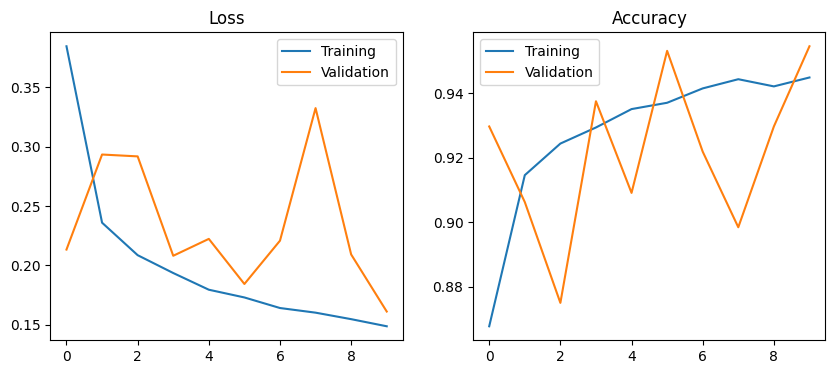

In [ ]:
def plot_history(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(history.history['loss'], label="Training")
    plt.plot(history.history['val_loss'], label="Validation")
    plt.title("Loss")
    plt.legend()

    plt.subplot(122)
    plt.plot(history.history['accuracy'], label="Training")
    plt.plot(history.history['val_accuracy'], label="Validation")
    plt.title("Accuracy")

    plt.legend()
    plt.show()

plot_history(model1a_history)

En este caso, con pocas epocas ya se obtienen muy buenos resultados. Logrando un accuracy de 95%. Resultando en una arquitectura muy eficiente en términos de tiempos y consumo de recursos.


## **Conclusion**:
Los mejores resultados obtenidos para resolver este problema fueron con *transfer learning*. Es de esperar que para esta tarea de clasificar un dataset relativamente pequeño (si lo comparamos con ImageNet el cual fue entrenado InceptionNet) el backbone seleccionado funcione bien.
